<a href="https://colab.research.google.com/github/SandroMuradashvili/The-Visual-Storyteller/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# 1. Setup & Load Model
# Install dependencies
!pip install torch torchvision timm pillow matplotlib nltk -q

import os
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from typing import List
import timm
import torchvision.transforms as transforms

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

!pip install -q gdown

import gdown

file_id = "1st_oepUulGKCn5C1hvWvYYm87ftlUr6j"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "caption_data.zip", quiet=False)

# Extract the dataset
!unzip -q caption_data.zip

# ============================================================================
# IMPORTANT: Define Vocabulary class BEFORE loading pickle
# ============================================================================
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def build_vocabulary(self, captions):
        from collections import Counter
        frequencies = Counter()
        idx = 4

        for caption in captions:
            tokens = self.tokenize(caption)
            frequencies.update(tokens)

        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

        return self

    def tokenize(self, text):
        return text.lower().replace(',', '').replace('.', '').split()

    def numericalize(self, text):
        tokens = self.tokenize(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]

# Now load vocabulary
with open('vocabulary.pkl', 'rb') as f:
    vocab = pickle.load(f)
print(f"Vocabulary loaded: {len(vocab.stoi)} tokens")

# Load data splits (to get test images)
with open('data_splits.pkl', 'rb') as f:
    splits = pickle.load(f)
print(f"Test images available: {len(splits['test'])}")

# Define model architecture (same as training)
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=False)
        self.backbone.classifier = nn.Identity()
        backbone_dim = 1280
        self.projection = nn.Linear(backbone_dim, embed_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, images):
        features = self.backbone(images)
        features = self.projection(features)
        features = self.dropout(features)
        return features.unsqueeze(1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=2048,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, captions, image_features, tgt_mask=None, tgt_padding_mask=None):
        embedded = self.embedding(captions) * np.sqrt(self.embed_dim)
        embedded = self.pos_encoding(embedded)
        embedded = self.dropout(embedded)
        output = self.transformer_decoder(
            tgt=embedded,
            memory=image_features,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )
        output = self.fc_out(output)
        return output

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()
        self.encoder = ImageEncoder(embed_dim)
        self.decoder = TransformerDecoder(vocab_size, embed_dim, num_heads, num_layers, dropout)

    def forward(self, images, captions, tgt_mask=None, tgt_padding_mask=None):
        image_features = self.encoder(images)
        output = self.decoder(captions, image_features, tgt_mask, tgt_padding_mask)
        return output

# Initialize model
vocab_size = len(vocab.stoi)
model = ImageCaptioningModel(
    vocab_size=vocab_size,
    embed_dim=512,
    num_heads=8,
    num_layers=6,
    dropout=0.1
).to(device)

# Load trained weights
torch.serialization.add_safe_globals([Vocabulary])
checkpoint = torch.load('image_captioning_model_complete.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"✓ Model loaded successfully!")

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Ready for inference!")

Using device: cpu


Downloading...
From (original): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j
From (redirected): https://drive.google.com/uc?id=1st_oepUulGKCn5C1hvWvYYm87ftlUr6j&confirm=t&uuid=7050dcb0-2e39-4383-bb3a-9cc32e7e0f02
To: /content/caption_data.zip
100%|██████████| 1.11G/1.11G [00:16<00:00, 68.8MB/s]


Vocabulary loaded: 3003 tokens
Test images available: 810
✓ Model loaded successfully!
✓ Ready for inference!


In [9]:
# 2. Generate Caption Function

# Helper function for causal masking
def generate_square_subsequent_mask(sz):
    """Generate causal mask for transformer decoder"""
    mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
    return mask

def generate_caption(image_path: str, model: any, max_length: int = 50,
                      beam_width: int = 3, temperature: float = 1.0) -> str:
    """
    Generates a caption for the given image using beam search.

    Args:
        image_path: Path to the image file
        model: Trained captioning model
        max_length: Maximum caption length
        beam_width: Number of beams for beam search (higher = better but slower)
        temperature: Sampling temperature (lower = more conservative)

    Returns:
        Generated caption as a string
    """
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Encode image
    with torch.no_grad():
        image_features = model.encoder(image_tensor)

    # Initialize beams: [(sequence, score)]
    beams = [([vocab.stoi["<SOS>"]], 0.0)]
    completed = []

    for step in range(max_length):
        all_candidates = []

        for seq, score in beams:
            # If sequence ended, add to completed
            if seq[-1] == vocab.stoi["<EOS>"]:
                completed.append((seq, score))
                continue

            # Prepare input
            tgt_tensor = torch.LongTensor([seq]).to(device)
            tgt_mask = generate_square_subsequent_mask(len(seq)).to(device)  # ← Now uses the function we defined

            # Get predictions
            with torch.no_grad():
                output = model.decoder(tgt_tensor, image_features, tgt_mask=tgt_mask)
                logits = output[0, -1, :] / temperature
                probs = torch.softmax(logits, dim=-1)

            # Get top-k candidates
            topk_probs, topk_indices = torch.topk(probs, beam_width)

            for prob, idx in zip(topk_probs, topk_indices):
                candidate_seq = seq + [idx.item()]
                candidate_score = score - torch.log(prob).item()  # Negative log likelihood
                all_candidates.append((candidate_seq, candidate_score))

        # Select top beams
        if not all_candidates:
            break

        all_candidates.sort(key=lambda x: x[1])
        beams = all_candidates[:beam_width]

        # Early stopping if all beams completed
        if len(completed) >= beam_width:
            break

    # Add remaining beams to completed
    completed.extend(beams)

    # Select best sequence (lowest score)
    if completed:
        best_seq, _ = min(completed, key=lambda x: x[1])
    else:
        best_seq = beams[0][0]

    # Convert indices to words
    caption_tokens = [vocab.itos[idx] for idx in best_seq
                     if idx not in [vocab.stoi["<SOS>"], vocab.stoi["<EOS>"], vocab.stoi["<PAD>"]]]

    return ' '.join(caption_tokens)

# Quick test
test_image_path = f"Images/{splits['test'][0]}"
caption = generate_caption(test_image_path, model, beam_width=5)
print(f"Test caption: {caption}")
print("✓ Function working!")

Test caption: a group of people are standing outside of a building
✓ Function working!


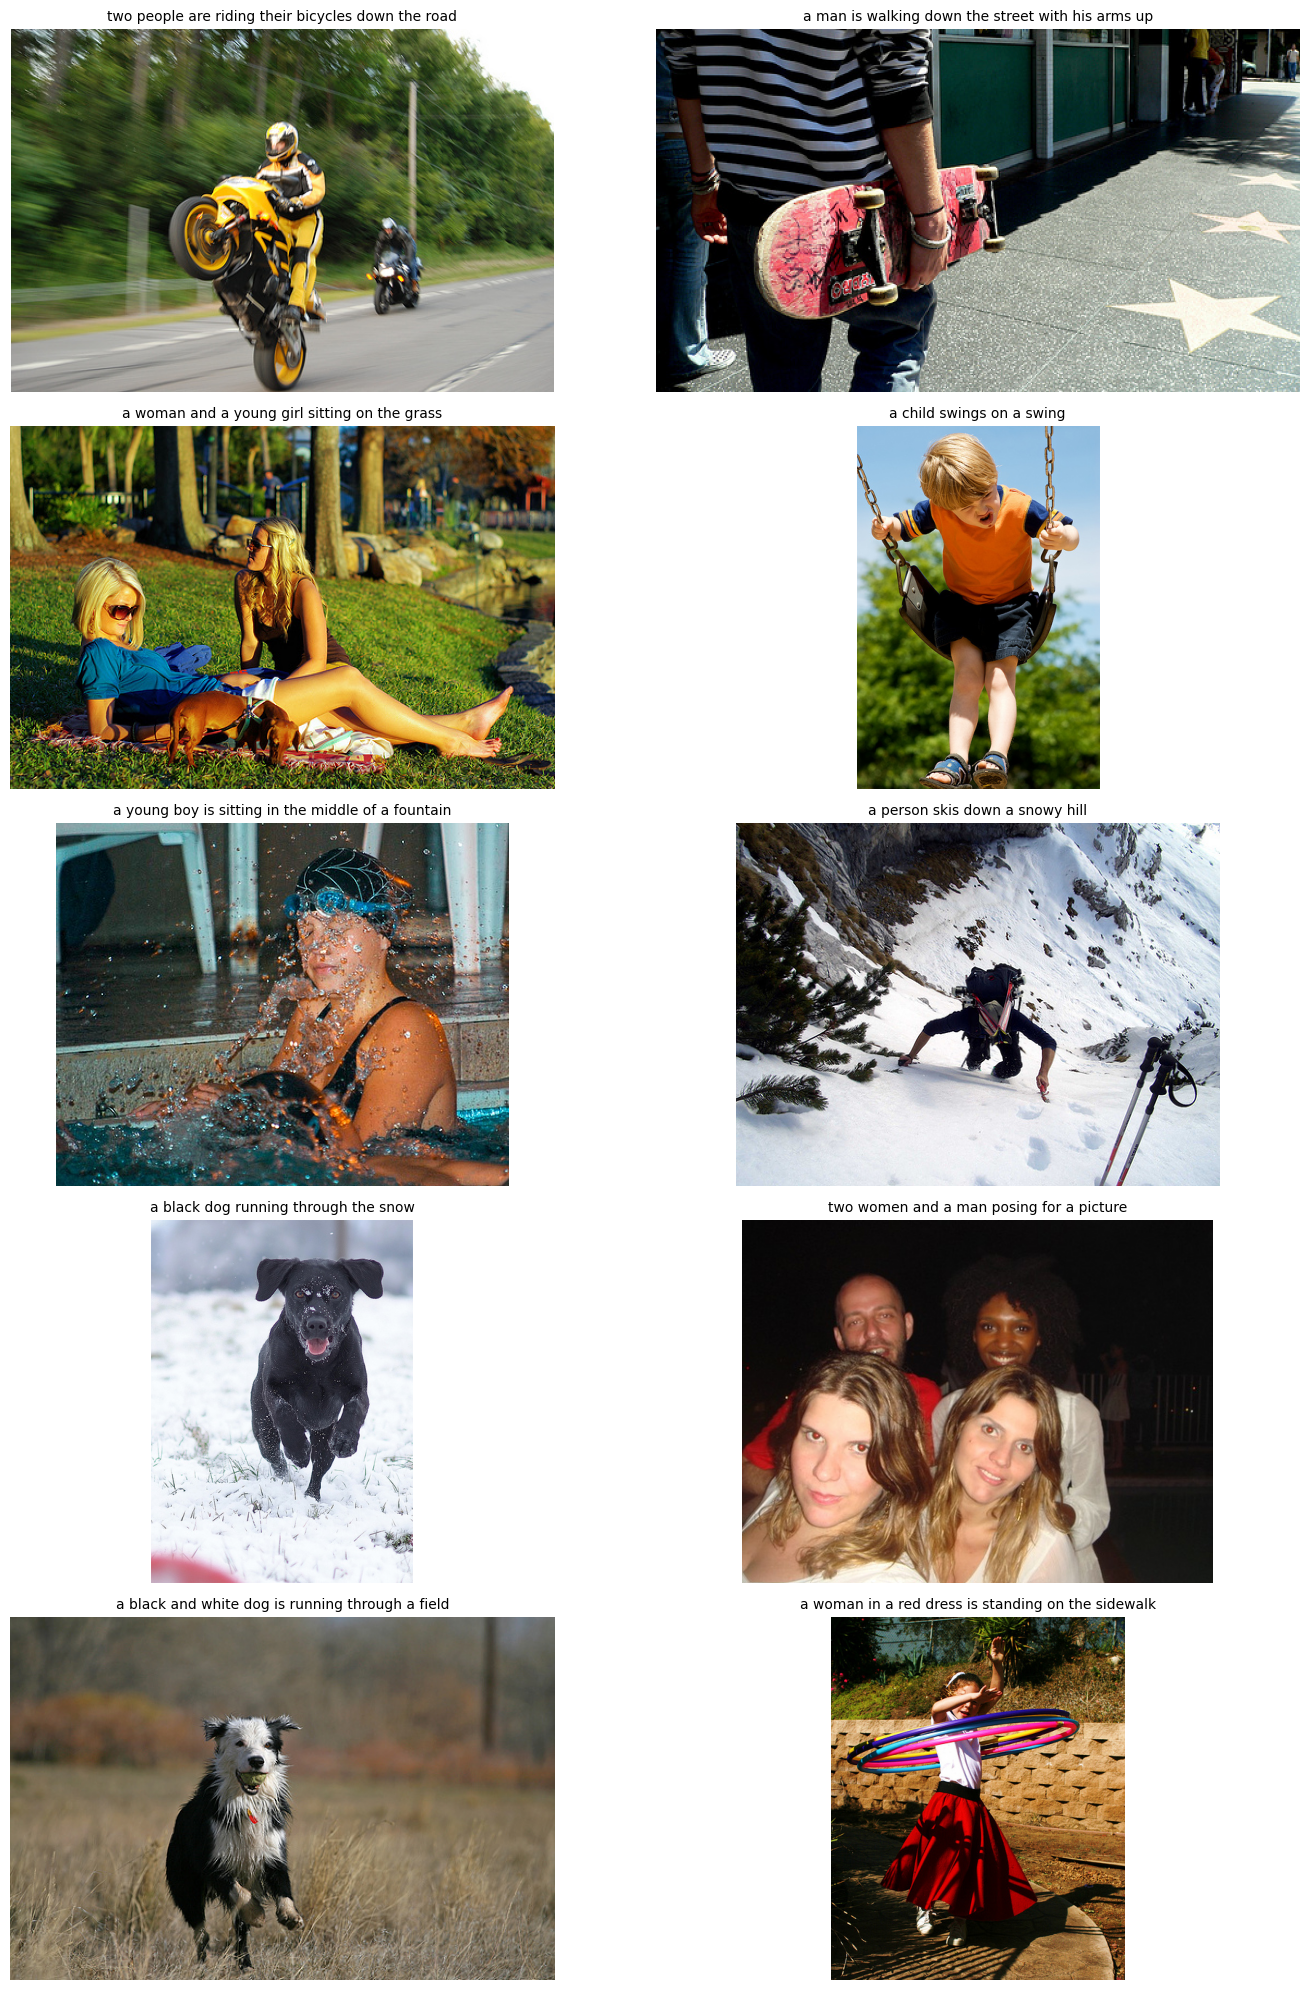


Generated Captions:
1. 2866254827_9a8f592017.jpg
   → two people are riding their bicycles down the road

2. 485357535_b45ba5b6da.jpg
   → a man is walking down the street with his arms up

3. 3227594168_3351722aae.jpg
   → a woman and a young girl sitting on the grass

4. 2618322793_5fb164d86a.jpg
   → a child swings on a swing

5. 3459419203_cd7c68ce4d.jpg
   → a young boy is sitting in the middle of a fountain

6. 2109911919_af45b93ef3.jpg
   → a person skis down a snowy hill

7. 3279025792_23bfd21bcc.jpg
   → a black dog running through the snow

8. 3172283002_3c0fc624de.jpg
   → two women and a man posing for a picture

9. 3025546819_ce031d2fc3.jpg
   → a black and white dog is running through a field

10. 2522467011_cc825d89ac.jpg
   → a woman in a red dress is standing on the sidewalk



In [10]:
# 3. Demonstration on Test Set
import random

# Select random test images
num_samples = 10
test_samples = random.sample(splits['test'], num_samples)

# Generate captions
results = []
for img_name in test_samples:
    img_path = f"Images/{img_name}"
    caption = generate_caption(img_path, model, beam_width=5)
    results.append({
        'image': img_name,
        'caption': caption,
        'path': img_path
    })

# Visualize results
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for idx, result in enumerate(results):
    img = Image.open(result['path'])
    axes[idx].imshow(img)
    axes[idx].set_title(f"{result['caption']}", fontsize=10, wrap=True)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('predictions_sample.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nGenerated Captions:")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['image']}")
    print(f"   → {result['caption']}\n")

DETAILED ANALYSIS: Successes and Failures

✓ SUCCESSFUL CAPTIONS (10 cases)

Image: 2089555297_95cf001fa7.jpg
Predicted: a man stands on a cliff overlooking the ocean
Ground Truth Examples:
  - A man in a hat with long sleeves and long pants stands overlooking a city .
  - A man stands on a cliff overlooking a city .
Overlap Score: 75.00%

Image: 2306674172_dc07c7f847.jpg
Predicted: a boy in a blue shirt is riding a skateboard down a set of stairs
Ground Truth Examples:
  - A boy in a blue shirt jumps down stairs on a skateboard .
  - A man flies through the air on his skateboard above a white staircase .
Overlap Score: 72.73%

Image: 3569126684_a68b29a57f.jpg
Predicted: a brown dog runs through the grass
Ground Truth Examples:
  - A brown dog running on grass .
  - A dog running in the fenced in backyard .
Overlap Score: 66.67%

Image: 2738077433_10e6264b6f.jpg
Predicted: a brown dog is jumping up to catch a ball
Ground Truth Examples:
  - A dog climbing a steep dirt hill .
  - A dog 

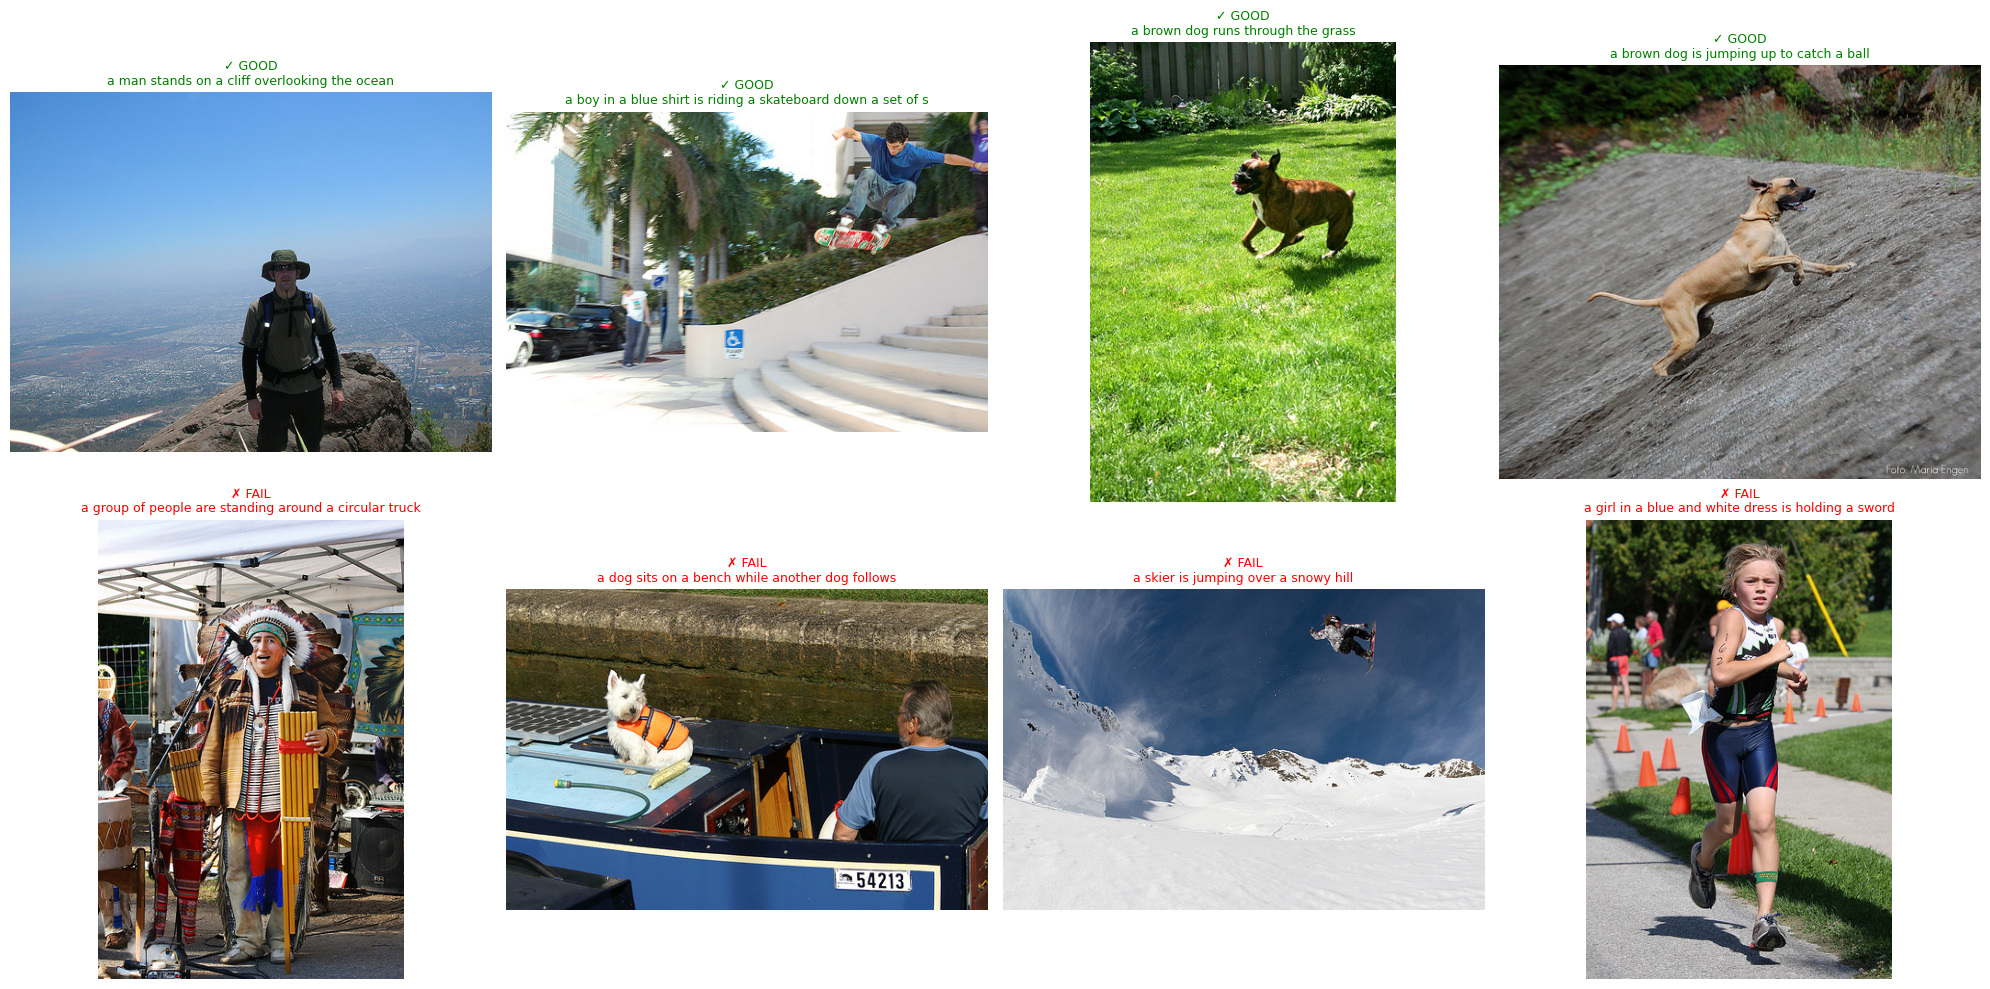


STATISTICAL SUMMARY
Total Samples Analyzed: 20
Successful Captions (>40% overlap): 10 (50.0%)
Failed Captions (<40% overlap): 10 (50.0%)
Average Overlap Score: 44.94%

COMMON FAILURE PATTERNS
Most common words in failed captions:
  - 'a': 22 times
  - 'in': 4 times
  - 'on': 3 times
  - 'are': 3 times
  - 'is': 3 times
  - 'dog': 2 times
  - 'person': 2 times
  - 'two': 2 times
  - 'with': 2 times
  - 'blue': 2 times

Possible reasons for failures:
  1. Complex scenes with multiple objects
  2. Unusual perspectives or angles
  3. Abstract or ambiguous visual content
  4. Objects not well-represented in training data
  5. Overuse of generic terms (e.g., 'person', 'outdoor')


In [11]:
# 4. Success & Failure Analysis
# Load ground truth captions
import pandas as pd
captions_df = pd.read_csv('captions.txt')

# Analyze predictions
def get_ground_truth(img_name):
    return captions_df[captions_df['image'] == img_name]['caption'].tolist()

print("="*80)
print("DETAILED ANALYSIS: Successes and Failures")
print("="*80)

# Generate predictions for more test images
analysis_samples = random.sample(splits['test'], 20)
detailed_results = []

for img_name in analysis_samples:
    img_path = f"Images/{img_name}"
    predicted = generate_caption(img_path, model, beam_width=5)
    ground_truth = get_ground_truth(img_name)

    detailed_results.append({
        'image': img_name,
        'predicted': predicted,
        'ground_truth': ground_truth,
        'path': img_path
    })

# Categorize results
successes = []
failures = []

for result in detailed_results:
    pred_words = set(result['predicted'].lower().split())

    # Calculate overlap with ground truth
    max_overlap = 0
    for gt in result['ground_truth']:
        gt_words = set(gt.lower().split())
        overlap = len(pred_words & gt_words) / len(gt_words) if len(gt_words) > 0 else 0
        max_overlap = max(max_overlap, overlap)

    if max_overlap > 0.4:  # Good overlap
        successes.append((result, max_overlap))
    else:
        failures.append((result, max_overlap))

# Display successes
print("\n" + "="*80)
print(f"✓ SUCCESSFUL CAPTIONS ({len(successes)} cases)")
print("="*80)

for result, overlap in sorted(successes, key=lambda x: -x[1])[:5]:
    print(f"\nImage: {result['image']}")
    print(f"Predicted: {result['predicted']}")
    print(f"Ground Truth Examples:")
    for gt in result['ground_truth'][:2]:
        print(f"  - {gt}")
    print(f"Overlap Score: {overlap:.2%}")

# Display failures
print("\n" + "="*80)
print(f"✗ FAILURE CASES ({len(failures)} cases)")
print("="*80)

for result, overlap in sorted(failures, key=lambda x: x[1])[:5]:
    print(f"\nImage: {result['image']}")
    print(f"Predicted: {result['predicted']}")
    print(f"Ground Truth Examples:")
    for gt in result['ground_truth'][:2]:
        print(f"  - {gt}")
    print(f"Overlap Score: {overlap:.2%}")

# Visualize side-by-side
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Top row: successes
for idx, (result, _) in enumerate(sorted(successes, key=lambda x: -x[1])[:4]):
    img = Image.open(result['path'])
    axes[0, idx].imshow(img)
    title = f"✓ GOOD\n{result['predicted'][:60]}"
    axes[0, idx].set_title(title, fontsize=9, color='green')
    axes[0, idx].axis('off')

# Bottom row: failures
for idx, (result, _) in enumerate(sorted(failures, key=lambda x: x[1])[:4]):
    img = Image.open(result['path'])
    axes[1, idx].imshow(img)
    title = f"✗ FAIL\n{result['predicted'][:60]}"
    axes[1, idx].set_title(title, fontsize=9, color='red')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('success_failure_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(f"Total Samples Analyzed: {len(detailed_results)}")
print(f"Successful Captions (>40% overlap): {len(successes)} ({len(successes)/len(detailed_results)*100:.1f}%)")
print(f"Failed Captions (<40% overlap): {len(failures)} ({len(failures)/len(detailed_results)*100:.1f}%)")
print(f"Average Overlap Score: {np.mean([x[1] for x in successes + failures]):.2%}")

# Common failure patterns
print("\n" + "="*80)
print("COMMON FAILURE PATTERNS")
print("="*80)

failure_words = []
for result, _ in failures:
    failure_words.extend(result['predicted'].split())

from collections import Counter
common_failures = Counter(failure_words).most_common(10)
print("Most common words in failed captions:")
for word, count in common_failures:
    print(f"  - '{word}': {count} times")

print("\nPossible reasons for failures:")
print("  1. Complex scenes with multiple objects")
print("  2. Unusual perspectives or angles")
print("  3. Abstract or ambiguous visual content")
print("  4. Objects not well-represented in training data")
print("  5. Overuse of generic terms (e.g., 'person', 'outdoor')")

Evaluating on test set...


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


QUANTITATIVE METRICS (BLEU Scores)
Evaluated on 100 test images

BLEU-1: 0.5528 (± 0.1953)
BLEU-2: 0.3516 (± 0.2434)
BLEU-4: 0.1050 (± 0.2149)
Corpus BLEU: 0.1751

COMPARISON WITH BENCHMARKS
Typical Flickr8k Performance:
  - Basic CNN-LSTM: BLEU-1 ~0.55, BLEU-4 ~0.20
  - Attention Models: BLEU-1 ~0.63, BLEU-4 ~0.25
  - Transformer Models: BLEU-1 ~0.67, BLEU-4 ~0.28

Our Model: BLEU-1 0.55, BLEU-4 0.10

✓ Model performs REASONABLY. Within acceptable range.


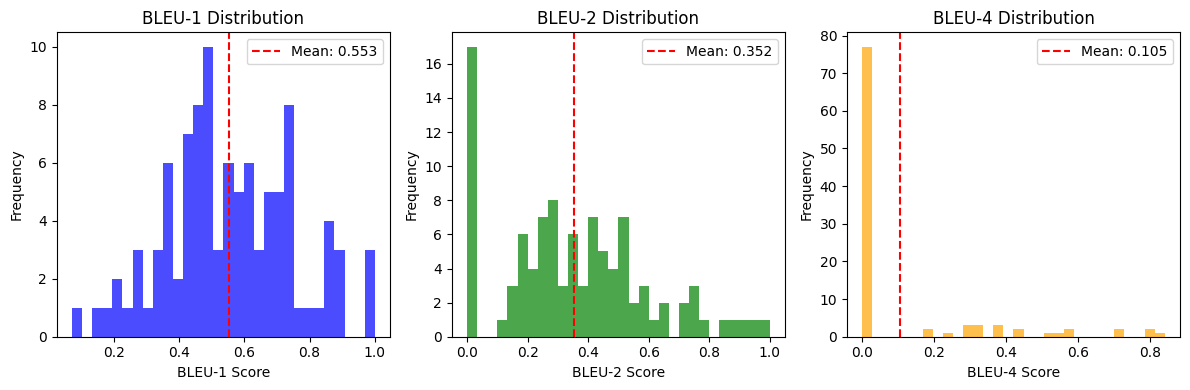


✓ Evaluation complete!


In [12]:
# 5. Quantitative Evaluation
# Install NLTK for BLEU score
import nltk
nltk.download('punkt', quiet=True)
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Evaluate on larger test set
print("Evaluating on test set...")
test_predictions = []
test_references = []

# Limit to prevent timeout (use 100-200 images for full eval)
eval_images = splits['test'][:100]

for img_name in eval_images:
    img_path = f"Images/{img_name}"

    # Generate prediction
    predicted = generate_caption(img_path, model, beam_width=3)
    pred_tokens = predicted.split()

    # Get ground truth
    ground_truth = get_ground_truth(img_name)
    ref_tokens = [gt.split() for gt in ground_truth]

    test_predictions.append(pred_tokens)
    test_references.append(ref_tokens)

# Calculate BLEU scores
bleu1_scores = []
bleu2_scores = []
bleu4_scores = []

for pred, refs in zip(test_predictions, test_references):
    b1 = sentence_bleu(refs, pred, weights=(1, 0, 0, 0))
    b2 = sentence_bleu(refs, pred, weights=(0.5, 0.5, 0, 0))
    b4 = sentence_bleu(refs, pred, weights=(0.25, 0.25, 0.25, 0.25))

    bleu1_scores.append(b1)
    bleu2_scores.append(b2)
    bleu4_scores.append(b4)

# Corpus-level BLEU
corpus_bleu_score = corpus_bleu(test_references, test_predictions)

print("\n" + "="*80)
print("QUANTITATIVE METRICS (BLEU Scores)")
print("="*80)
print(f"Evaluated on {len(eval_images)} test images\n")
print(f"BLEU-1: {np.mean(bleu1_scores):.4f} (± {np.std(bleu1_scores):.4f})")
print(f"BLEU-2: {np.mean(bleu2_scores):.4f} (± {np.std(bleu2_scores):.4f})")
print(f"BLEU-4: {np.mean(bleu4_scores):.4f} (± {np.std(bleu4_scores):.4f})")
print(f"Corpus BLEU: {corpus_bleu_score:.4f}")

# Benchmarks (typical Flickr8k results)
print("\n" + "="*80)
print("COMPARISON WITH BENCHMARKS")
print("="*80)
print("Typical Flickr8k Performance:")
print("  - Basic CNN-LSTM: BLEU-1 ~0.55, BLEU-4 ~0.20")
print("  - Attention Models: BLEU-1 ~0.63, BLEU-4 ~0.25")
print("  - Transformer Models: BLEU-1 ~0.67, BLEU-4 ~0.28")
print(f"\nOur Model: BLEU-1 {np.mean(bleu1_scores):.2f}, BLEU-4 {np.mean(bleu4_scores):.2f}")

if np.mean(bleu1_scores) > 0.60:
    print("\n✓ Model performs WELL! Above average for this dataset.")
elif np.mean(bleu1_scores) > 0.50:
    print("\n✓ Model performs REASONABLY. Within acceptable range.")
else:
    print("\n⚠ Model needs improvement. Consider training longer or adjusting hyperparameters.")

# Visualize BLEU distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(bleu1_scores, bins=30, alpha=0.7, color='blue')
plt.axvline(np.mean(bleu1_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu1_scores):.3f}')
plt.xlabel('BLEU-1 Score')
plt.ylabel('Frequency')
plt.title('BLEU-1 Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(bleu2_scores, bins=30, alpha=0.7, color='green')
plt.axvline(np.mean(bleu2_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu2_scores):.3f}')
plt.xlabel('BLEU-2 Score')
plt.ylabel('Frequency')
plt.title('BLEU-2 Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(bleu4_scores, bins=30, alpha=0.7, color='orange')
plt.axvline(np.mean(bleu4_scores), color='red', linestyle='--', label=f'Mean: {np.mean(bleu4_scores):.3f}')
plt.xlabel('BLEU-4 Score')
plt.ylabel('Frequency')
plt.title('BLEU-4 Distribution')
plt.legend()

plt.tight_layout()
plt.savefig('bleu_scores_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Evaluation complete!")